In [1]:
from ddganAE.models import AAE, AAE_combined_loss, CAE, SVDAE
from ddganAE.architectures.cae.D3 import *
from ddganAE.architectures.svdae import *
from ddganAE.architectures.discriminators import *
from ddganAE.preprocessing import convert_2d
from keras.regularizers import l2
from ddganAE.utils import calc_pod
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds, eigs

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3676631181635456400
]


# Let's look at data

In [15]:
grids = np.load("./../submodules/DD-GAN/data/processed/sf_snapshots_800steps_notrand.npy")

In [16]:
grids.shape

(8000, 60, 20, 20, 4)

In [17]:
np.sum(grids[:,:,:,:,1])

170782.55

In [18]:
# Set all >0 to 0 and all <1 to 1 for alpha field


grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] < 0)] = 0
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] > 1)] = 1

(array([  342.,   316.,   360.,   425.,   426.,   501.,   550.,   602.,
          647.,   719.,   777.,   898.,   961.,  1129.,  1287.,  1250.,
         1466.,  1615.,  1779.,  2011.,  2205.,  2431.,  2642.,  2870.,
         3068.,  3313.,  3745.,  4096.,  4341.,  4699.,  5090.,  5389.,
         6126.,  6316.,  6891.,  7398.,  8104.,  8321.,  8988.,  9543.,
         9978., 10525., 10988., 11328., 11907., 12046., 12507., 12414.,
        12531., 12275., 12002., 11968., 11807., 12011., 11143., 10945.,
        10693., 10357.,  9872.,  9428.,  8997.,  8685.,  8281.,  7598.,
         7381.,  6993.,  6302.,  6088.,  5466.,  5227.,  4907.,  4454.,
         4130.,  3741.,  3373.,  3102.,  2767.,  2516.,  2322.,  2171.,
         1868.,  1705.,  1652.,  1439.,  1259.,  1129.,  1039.,   961.,
          833.,   764.,   701.,   591.,   587.,   483.,   449.,   432.,
          388.,   368.,   312.,   256.]),
 array([-0.1  , -0.098, -0.096, -0.094, -0.092, -0.09 , -0.088, -0.086,
        -0.084, -0.082

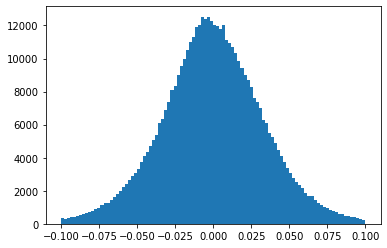

In [33]:
plt.hist(grids[80:100,:,:,:,1].reshape(-1), bins=100, range=(-0.1, 0.1))

In [34]:
np.sum(grids[:,:,:,:,2] == 0)

240002

In [35]:
grids_minav = grids[:,:,:,:,:3] - np.mean(grids[:,:,:,:,:3])

(array([4.00000000e+00, 1.00000000e+00, 6.50000000e+01, 1.59000000e+02,
        1.00900000e+03, 1.28920000e+04, 2.62232000e+05, 2.51568690e+07,
        3.61601084e+08, 2.00104660e+07, 6.19924590e+07, 3.90769140e+07,
        3.09748330e+07, 1.87032780e+07, 7.91446600e+06, 4.55104100e+06,
        3.00706800e+06, 1.55671100e+06, 7.19271000e+05, 3.14306000e+05,
        1.10804000e+05, 2.63900000e+04, 6.02800000e+03, 1.15500000e+03,
        2.88000000e+02, 1.21000000e+02, 5.70000000e+01, 1.90000000e+01,
        3.00000000e+00, 7.00000000e+00]),
 array([-7.918031  , -7.065709  , -6.213387  , -5.3610654 , -4.5087433 ,
        -3.6564212 , -2.8040993 , -1.9517773 , -1.0994552 , -0.2471333 ,
         0.60518867,  1.4575107 ,  2.3098326 ,  3.1621547 ,  4.014477  ,
         4.8667984 ,  5.7191205 ,  6.5714426 ,  7.4237647 ,  8.276087  ,
         9.128408  ,  9.980731  , 10.833053  , 11.685374  , 12.537697  ,
        13.390018  , 14.24234   , 15.094663  , 15.946984  , 16.799307  ,
        17.65162

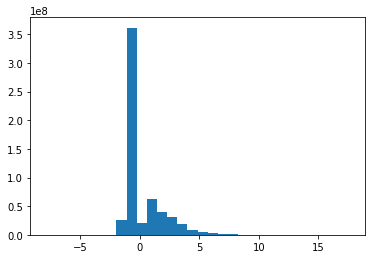

In [36]:
plt.hist(grids_minav.reshape(-1), bins=30)

In [8]:
# Rescale all the velocity fields

# Try scaling fields individually

scaler = MinMaxScaler()
grids[:,:,:,:,:3] = scaler.fit_transform(grids[:,:,:,:,:3].reshape(-1, 1)).reshape(grids[:,:,:,:,:3].shape)

In [9]:
grid = grids[3000, 10, :, :, 3]
fig, ax = plt.subplots()
ax.contourf(grid)

IndexError: index 3000 is out of bounds for axis 0 with size 20

In [10]:
grids.shape

(20, 60, 20, 20, 4)

# POD

### Data preprocessing

In [47]:
grids = np.load("./../submodules/DD-GAN/data/processed/sf_snapshots_800steps_notrand.npy")
# Set all >0 to 0 and all <1 to 1 for alpha field
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] < 0)] = 0
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] > 1)] = 1

In [48]:
grids.shape

(8000, 60, 20, 20, 4)

In [49]:
# Rescale all the velocity fields
scaler = MinMaxScaler()
grids[:,:,:,:,:3] = grids[:,:,:,:,:3] - np.mean(grids[:,:,:,:,:3])
grids[:,:,:,:,:3] = scaler.fit_transform(grids[:,:,:,:,:3].reshape(-1, 1)).reshape(grids[:,:,:,:,:3].shape)

In [50]:
np.mean(grids[:,:,:,:,:3])

0.30967274

In [51]:
grids_reshaped = grids.reshape((int(grids.shape[0]/10), 10, grids.shape[1], grids.shape[2], grids.shape[3], grids.shape[4]))
grids_long = np.moveaxis(grids_reshaped, 1, 5).reshape((grids_reshaped.shape[0], -1, grids_reshaped.shape[1]))
grids_long = np.swapaxes(grids_long, 0, 2)

### Do actual pod

In [52]:
coeffs, R, s = calc_pod(grids_long, nPOD=10)

SSmatrix (8000, 8000)


In [53]:
grids_long.shape

(10, 96000, 800)

In [54]:
np.save("coeffs", coeffs)
np.save("R", R)

### Check reconstruction loss

In [55]:
# Reconstruct the first subgrid
recon = R @ coeffs[0]
print(recon, '\n',
      grids_long[0, :, :])

np.allclose(recon, grids_long[0, :, :], atol=0.2)

[[0.37239499 0.36889276 0.36838554 ... 0.34658897 0.34671825 0.34686577]
 [0.27527709 0.27108689 0.27034591 ... 0.27206136 0.27202311 0.27200238]
 [0.27537939 0.27102399 0.27019121 ... 0.27115152 0.27111214 0.27109326]
 ...
 [0.27542806 0.27084932 0.26984714 ... 0.27524186 0.27516751 0.27511119]
 [0.27594349 0.27225244 0.27177349 ... 0.27202771 0.27202905 0.27204377]
 [0.99017322 0.99704339 1.00410297 ... 0.06791485 0.07446092 0.0804375 ]] 
 [[0.3484773  0.35124916 0.35127985 ... 0.35105097 0.35107026 0.3510788 ]
 [0.27025962 0.27023235 0.270426   ... 0.27061093 0.2706107  0.27060437]
 [0.27025962 0.27010944 0.2704057  ... 0.27061543 0.27057827 0.2706132 ]
 ...
 [0.27025962 0.27291393 0.27421522 ... 0.279011   0.27796963 0.27988467]
 [0.27025962 0.2677752  0.2729421  ... 0.28555048 0.2842072  0.2795431 ]
 [1.         1.         1.         ... 0.01005683 0.00990777 0.01018753]]


False

In [56]:
# Calculate MSE
mean = 0
recon_grid = np.zeros(grids_long.shape)
for j in range(10):
    recon = R @ coeffs[j]
    for i in range(800):
        mean += tf.keras.losses.MSE(recon[:, i], grids_long[j, :, i]).numpy()/8000
    recon_grid[j, :, :] = recon
print(mean)

0.0021950925407295437


In [57]:
recon_grid.shape

(10, 96000, 800)

In [58]:
0.0021950925333260314

0.0021950925333260314

### Reconstruct back to original shape and rescale

In [ ]:
grids_recon = np.moveaxis(recon_grid, 2, 0).reshape(*grids.shape)
grids_recon[:,:,:,:,:3] = scaler.inverse_transform(grids_recon[:,:,:,:,:3].reshape(-1, 1)).reshape(grids_recon[:,:,:,:,:3].shape)
#grids_recon[:,:,:,:,:3] += np.mean(grids[:,:,:,:,:3])

In [ ]:
idx = 2000
grid = grids[idx, 10, :, :, 0]
grid_recon = grids_recon[idx, 10, :, :, 0]
fig, ax = plt.subplots(1,2)
ax[0].contourf(grid)
ax[1].contourf(grid_recon)

In [ ]:
# reshape to (ngrids, nscalar, nx, ny, nz, ntime)
np.save("pod_10vars_prediction_sf.npy", grids_recon[:, :, :, :, :])

In [26]:
grids_recon.shape

(8000, 60, 20, 20, 4)

# Convolutional Autoencoder

### Data preprocessing

In [2]:
grids = np.load("./../submodules/DD-GAN/data/processed/sf_snapshots_2timesteps_notrand.npy")

In [3]:
grids.shape

(20, 60, 20, 20, 4)

In [4]:
# Set all >0 to 0 and all <1 to 1 for alpha field
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] < 0)] = 0
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] > 1)] = 1

In [5]:
# Rescale all the velocity fields
scaler = MinMaxScaler()
grids[:,:,:,:,:3] = scaler.fit_transform(grids[:,:,:,:,:3].reshape(-1, 1)).reshape(grids[:,:,:,:,:3].shape)

In [6]:
x_train, x_val = train_test_split(grids, test_size=0.1)

### Model setup

In [7]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.00005, beta_1=0.9, beta_2=0.999)

input_shape = (60, 20, 20, 4)

encoder, decoder = build_deeper_omata_encoder_decoder(input_shape, 10, initializer, info=True, act='elu', dense_act='relu')

cae = CAE(encoder, decoder, optimizer)
cae.compile(input_shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 60, 20, 20, 32)    16032     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 30, 10, 10, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 30, 10, 10, 64)    55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 5, 5, 64)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 5, 5, 64)      110656    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 8, 3, 3, 64)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 8, 3, 3, 128)      2

In [8]:
cae.train(grids, 50, val_data=grids, batch_size=2)

### Predict and generate outputs

In [9]:
grids = np.load("./../submodules/DD-GAN/data/processed/sf_snapshots_2timesteps_notrand.npy")

# Set all >0 to 0 and all <1 to 1 for alpha field
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] < 0)] = 0
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] > 1)] = 1

# Rescale all the velocity fields
scaler = MinMaxScaler()
grids[:,:,:,:,:3] = scaler.fit_transform(grids[:,:,:,:,:3].reshape(-1, 1)).reshape(grids[:,:,:,:,:3].shape)

In [10]:
out_grids = cae.predict(grids)

In [11]:
out_grids.shape

(20, 60, 20, 20, 4)

In [12]:
# reshape to (ngrids, nscalar, nx, ny, nz, ntime)
np.save("cae_prediction_sf.npy", out_grids)

In [13]:
out_grids.shape

(20, 60, 20, 20, 4)

In [1]:
out = out_grids[6, 10, :, :, 0]
orig = grids[6, 10, :, :, 0]

NameError: name 'out_grids' is not defined

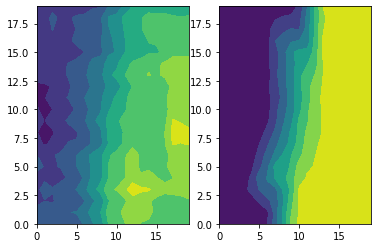

In [15]:
fig, ax = plt.subplots(1,2)
ax[0].contourf(out)
ax[1].contourf(orig)

# Adversarial Autoencoder

### Preprocessing

In [2]:
grids = np.load("./../submodules/DD-GAN/data/processed/sf_snapshots_2timesteps_notrand.npy")

In [3]:
# Set all >0 to 0 and all <1 to 1 for alpha field
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] < 0)] = 0
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] > 1)] = 1

In [4]:
# Rescale all the velocity fields
scaler = MinMaxScaler()
grids[:,:,:,:,:3] = scaler.fit_transform(grids[:,:,:,:,:3].reshape(-1, 1)).reshape(grids[:,:,:,:,:3].shape)

In [5]:
x_train, x_val = train_test_split(grids, test_size=0.1)

In [6]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.00005, beta_1=0.9, beta_2=0.999)

input_shape = (60, 20, 20, 4)

encoder, decoder = build_deeper_omata_encoder_decoder(input_shape, 10, initializer, info=True, act='elu', dense_act='relu')
discriminator = build_custom_discriminator(10, initializer, info=True)

aae = AAE_combined_loss(encoder, decoder, discriminator, optimizer)
aae.compile(input_shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 60, 20, 20, 32)    16032     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 30, 10, 10, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 30, 10, 10, 64)    55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 5, 5, 64)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 5, 5, 64)      110656    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 8, 3, 3, 64)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 8, 3, 3, 128)      2

In [7]:
aae.train(x_train, 50, val_data=x_val, batch_size=2, val_batch_size=2)

KeyboardInterrupt: 

# SVD Autoencoder

### Preprocessing

In [2]:
grids = np.load("./../submodules/DD-GAN/data/processed/sf_snapshots_2timesteps_notrand.npy")
# Set all >0 to 0 and all <1 to 1 for alpha field
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] < 0)] = 0
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] > 1)] = 1

In [3]:
# Rescale all the velocity fields
scaler = MinMaxScaler()
grids[:,:,:,:,:3] = scaler.fit_transform(grids[:,:,:,:,:3].reshape(-1, 1)).reshape(grids[:,:,:,:,:3].shape)

In [4]:
x_train, x_val = train_test_split(grids, test_size=0.1 )

In [5]:
x_train_long = np.moveaxis(np.moveaxis(x_train, 4, 0), 1, 4).reshape((x_train.shape[-1], x_train.shape[1]*x_train.shape[2]*x_train.shape[3], x_train.shape[0]))
x_val_long = np.moveaxis(np.moveaxis(x_val, 4, 0), 1, 4).reshape((x_val.shape[-1], x_val.shape[1]*x_val.shape[2]*x_val.shape[3], x_val.shape[0]))

### Set up model

In [2]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.0005, beta_1=0.98, beta_2=0.99999)

encoder, decoder = build_vinicius_encoder_decoder(100, 10, initializer, act='elu', dense_act='relu', info=True, reg=0, dropout=0.55, batchnorm=False)

NameError: name 'tf' is not defined

In [7]:
svdae = SVDAE(encoder, decoder, optimizer)
svdae.compile(100, weight_loss=False)

# Only set this when loading in the model
#svdae.R = np.load("R_svdae.npy")

In [8]:
svdae.train(x_train_long, 150, val_data=x_val_long, batch_size=2, val_batch_size=2)

In [15]:
original = x_train_long[0, :, 15]
original.shape

(24000,)

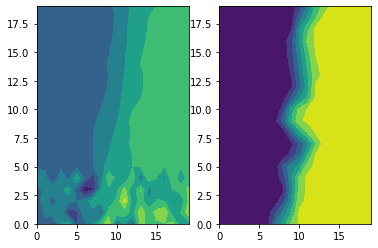

In [16]:
result = svdae.predict_single(original)
result = result.reshape((1, 60, 20, 20, 1))

original = original.reshape((1, 60, 20, 20, 1))

fig, ax = plt.subplots(1,2)
ax[0].contourf(result[0][0, :, :, 0])
ax[1].contourf(original[0][0, :, :, 0])

In [ ]:
Create data on the fly! Keep randomly sampling!

In [10]:
grids_recon = np.load("./../submodules/DD-GAN/data/processed/cae_prediction_sf_100vars_800steps.npy")

In [22]:
grids_recon[:,:,:,:,:3] = scaler.inverse_transform(grids_recon[:,:,:,:,:3].reshape(-1, 1)).reshape(grids_recon[:,:,:,:,:3].shape)

In [14]:
np.max(grids_recon[:,:,:,:,3])

1.2378416

In [4]:
grids_recon.shape

(8000, 60, 20, 20, 4)

In [12]:
grids_recon = grids_recon[7000:, :, :, :, :]

In [13]:
np.save("./../submodules/DD-GAN/data/processed/cae_prediction_sf_100vars_final100.npy", grids_recon)

In [8]:
grids_recon.shape

(400, 60, 20, 20, 4)

In [106]:
recon = grids_recon[1104, 10, :, :, 3]
orig = grids[1104, 10, :, :, 3]

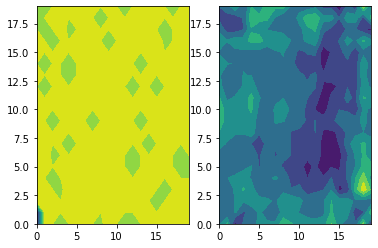

In [107]:
fig, ax = plt.subplots(1,2)
ax[0].contourf(orig)
ax[1].contourf(recon)